In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import seaborn as sns

from netam import shmoof, noof

In [2]:
train_df, val_df = shmoof.load_shmoof_dataframes("/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv") #, sample_count=5000)

In [3]:
kmer_length = 5
max_length = 410

train_dataset = shmoof.SHMoofDataset(train_df, kmer_length=kmer_length, max_length=max_length)
val_dataset = shmoof.SHMoofDataset(val_df, kmer_length=kmer_length, max_length=max_length)

print(f"we have {len(train_dataset)} training examples and {len(val_dataset)} validation examples")

In [ ]:
model = shmoof.SHMoofModel(train_dataset)
burrito = shmoof.NoofBurrito(train_dataset, val_dataset, model, batch_size=1024, learning_rate=0.1, l2_regularization_coeff=1e-6)
print("starting training...")
losses = burrito.train(epochs=100)
model.write_shmoof_output("_ignore/reshmoof")

starting training...
Epoch [1/10]	 Loss: 0.062804028	 Val Loss: 0.066816521
Epoch [2/10]	 Loss: 0.058529565	 Val Loss: 0.06652407
Epoch [3/10]	 Loss: 0.058455496	 Val Loss: 0.066539413
Epoch [4/10]	 Loss: 0.05845167	 Val Loss: 0.066518341
Epoch [5/10]	 Loss: 0.058453445	 Val Loss: 0.066528722
Epoch [6/10]	 Loss: 0.058445537	 Val Loss: 0.06653978
Epoch [7/10]	 Loss: 0.058446184	 Val Loss: 0.066504039
Epoch [8/10]	 Loss: 0.0584426	 Val Loss: 0.066532652
Epoch [9/10]	 Loss: 0.058454489	 Val Loss: 0.066478433
Epoch [10/10]	 Loss: 0.058453485	 Val Loss: 0.066570461


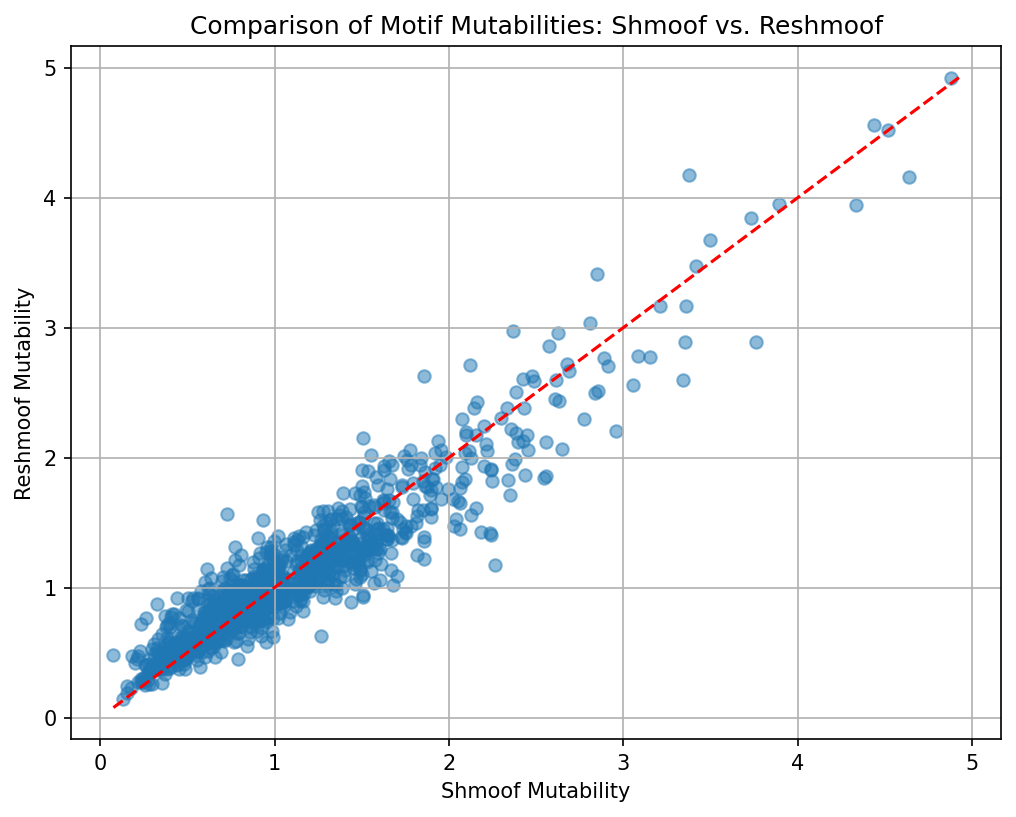

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load motif mutabilities
shmoof_motifs = pd.read_csv('_ignore/original_shmoof/mutabilities_context.tsv', sep='\t')
reshmoof_motifs = pd.read_csv('_ignore/reshmoof/motif_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_motifs = pd.merge(shmoof_motifs, reshmoof_motifs, on='Motif', how='inner', suffixes=('_shmoof', '_reshmoof'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_motifs['Mutability_shmoof'], merged_motifs['Mutability_reshmoof'], alpha=0.5)

# Determine bounds for y=x line
min_bound = min(merged_motifs['Mutability_shmoof'].min(), merged_motifs['Mutability_reshmoof'].min())
max_bound = max(merged_motifs['Mutability_shmoof'].max(), merged_motifs['Mutability_reshmoof'].max())

# Add y=x line
plt.plot([min_bound, max_bound], [min_bound, max_bound], 'r--')

plt.xlabel('Shmoof Mutability')
plt.ylabel('Reshmoof Mutability')
plt.title('Comparison of Motif Mutabilities: Shmoof vs. Reshmoof')
plt.grid(True)
plt.show()

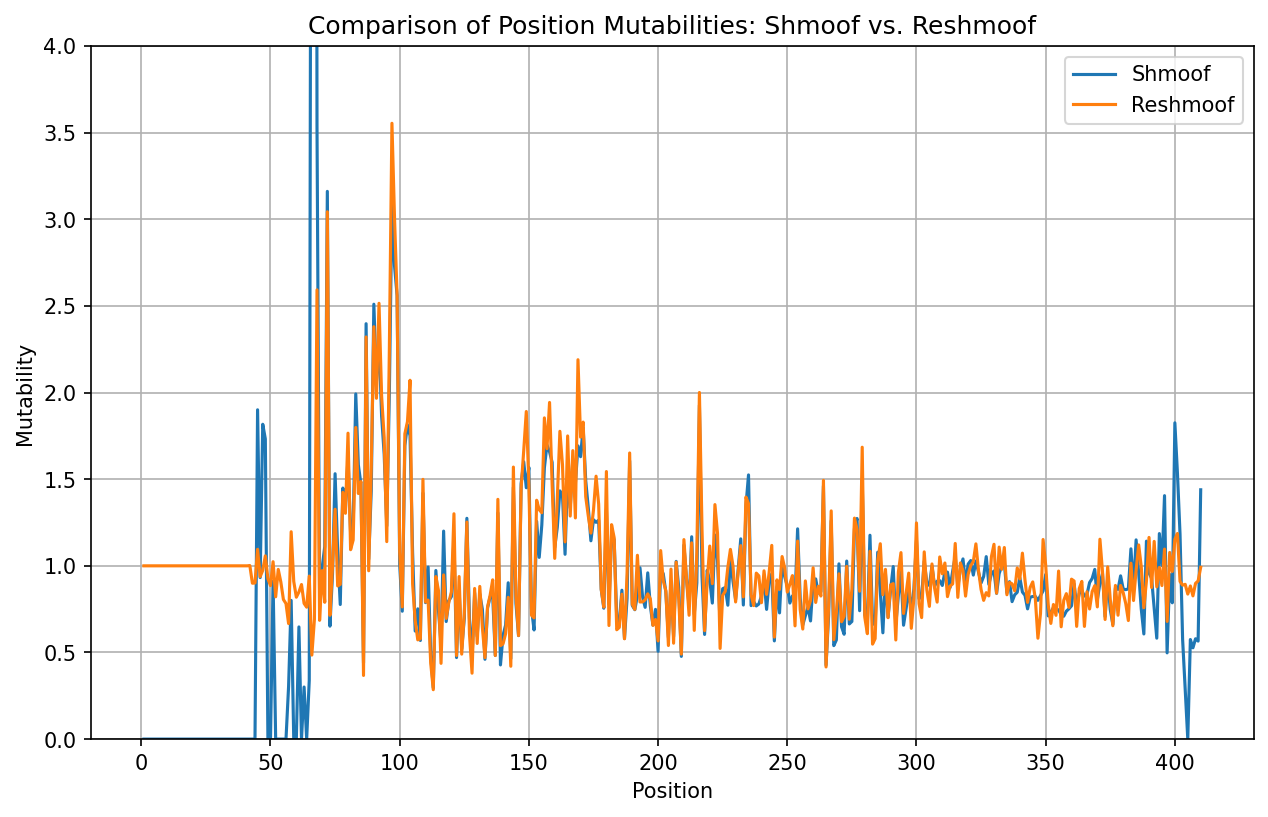

In [ ]:
# Load position mutabilities
shmoof_positions = pd.read_csv('_ignore/original_shmoof/mutabilities_position.tsv', sep='\t')
reshmoof_positions = pd.read_csv('_ignore/reshmoof/site_mutabilities.tsv', sep='\t')

# Merge dataframes
merged_positions = pd.merge(shmoof_positions, reshmoof_positions, on='Position', suffixes=('_shmoof', '_reshmoof'))
merged_positions.sort_values(by='Position', inplace=True)

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof')
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.ylim(0, 4)

plt.title('Comparison of Position Mutabilities: Shmoof vs. Reshmoof')
plt.legend()
plt.grid(True)
plt.show()


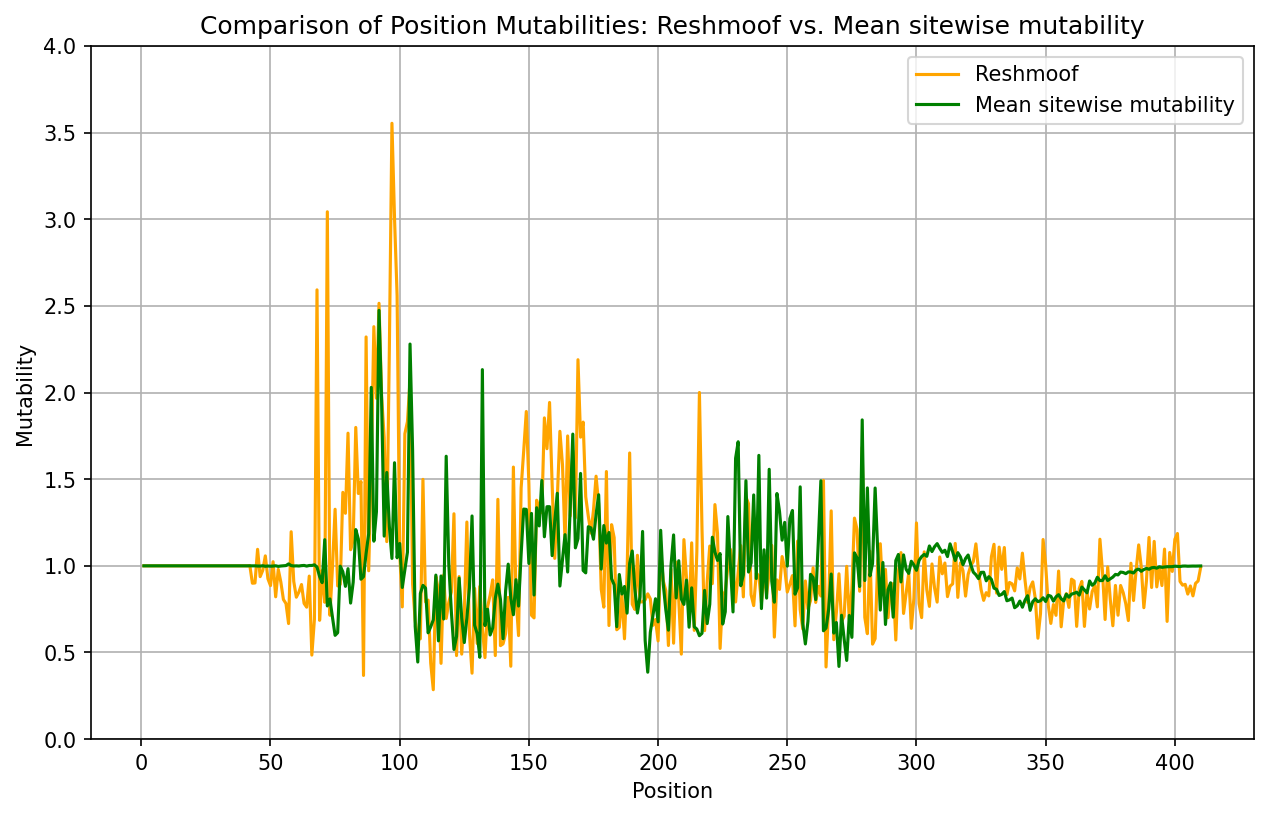

In [ ]:
kmer_mutabilities = []

# turn reshmoof_motifs into a dict mapping "Motif" to "Mutability"
reshmoof_motifs_dict = dict(zip(reshmoof_motifs["Motif"], reshmoof_motifs["Mutability"]))

for parent in train_df["parent"]:
    kmer_mutability = np.ones(410)
    padded_parent = "NN" + parent + "NN"
    for i in range(min(410, len(padded_parent) - 5)):
        kmer_mutability[i] = reshmoof_motifs_dict.get(padded_parent[i:i+5], 1.0)
    kmer_mutabilities.append(kmer_mutability)

[kmer_mutability.shape for kmer_mutability in kmer_mutabilities]

mean_sitewise_mutability = np.stack(kmer_mutabilities).mean(axis=0)
mean_sitewise_mutability = pd.Series(mean_sitewise_mutability)

plt.figure(figsize=(10, 6))
# plt.plot(merged_positions['Position'], merged_positions['Mutability_shmoof'], label='Shmoof')
plt.plot(merged_positions['Position'], merged_positions['Mutability_reshmoof'], label='Reshmoof', color='orange')
plt.plot(merged_positions['Position'], mean_sitewise_mutability, label='Mean sitewise mutability', color='green')
# plt.xlim(75, 200)
plt.ylim(0, 4)
plt.xlabel('Position')
plt.ylabel('Mutability')
plt.title('Comparison of Position Mutabilities: Reshmoof vs. Mean sitewise mutability')
plt.legend()
plt.grid(True)
plt.show()
